In [1]:
#Import Packages

#Database
from arango import ArangoClient
import getpass

#Text - Pandas
import pandas as pd
import re
import pickle

#Feature Extraction & Models
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix ,accuracy_score, classification_report 
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB, ComplementNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
import gensim

#Miscellaneous
from IPython.display import clear_output
from tqdm import tqdm
import time
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# Database Connection

username = input('Please enter your username to connect DB: ')
password = getpass.getpass('Please enter your password to connect DB: ')
try:
    client = ArangoClient(hosts='http://127.0.0.1:8529')
    try:
        FBW = client.db('Flemish_Business_Websites', username=username, password=password, verify=True)
    except:
        raise ConnectionError("Bad Connection")
    clear_output(wait=True)
    print('Successfully connected to the ArangoDB')
    del password
except ConnectionError:
    clear_output(wait=True)
    print('Warning: Please check your credentials and try to connect again!')
    del password

BusinessCollection = FBW.collection('Businesses')

Successfully connected to the ArangoDB


In [3]:
#To randomly sample quickly get unique id's 
unique_id_list = []

cursor = FBW.aql.execute('FOR doc IN Businesses RETURN doc', ttl=5000)
for document in cursor:
    if(("Final_Text_IR01" in document) and ("Innovation" in document)):
        unique_id_list.append(document["_key"])
        
print("Unique keys in list: ", len(unique_id_list))

Unique keys in list:  2746


In [5]:
#Save 1000 random seeds that will be used in data splits - Initial seed is birthday (ddmyy)
random.seed(22494)
random_seeds_list = [random.randint(0,100000) for i in range(100)]

In [4]:
#Required Functions

#Randomly sample datasets
def random_split(keys, seed, percent):
    random.seed(seed)
    return random.sample(keys, k=int(len(keys)*percent))

#Form a dataframe to easy access text and innovation
def database_to_dataframe(revision):
    key = []
    text = []
    innovation = []
    cursor = FBW.aql.execute('FOR doc IN Businesses RETURN doc', ttl=5000)
    for document in cursor:
        if((revision in document) and ("Innovation" in document)):
            key.append(document["_key"])
            text.append(document[revision])
            innovation.append(document["Innovation"])
    return pd.DataFrame({'key': key,'text': text,'innovation': innovation})

#Get text and innovation without transforming TF-IDF
def sets(dataset, seed, fraction, oversample = False, size = 0):
    train_temp = dataset.sample(frac = fraction, random_state = seed)
    test_temp = dataset.drop(train_temp.index)
    if(oversample):
        train_temp = oversample_category(train_temp, 0, size, 22494)
    train_predictors = train_temp['text']
    test_redictors = test_temp['text']
    return train_predictors, train_temp['innovation'], test_redictors, test_temp['innovation']

#############################################################
#Feature Extraction
#############################################################

#Get Train Test Sets of TF-IDF
def TFIDF_sets(dataset, seed, fraction, feature_count, oversample = False, size = 0):
    train_temp = dataset.sample(frac = fraction, random_state = seed)
    test_temp = dataset.drop(train_temp.index)
    if(oversample):
        train_temp = oversample_category(train_temp, 0, size, 22494)
    TFIDF_vectorizer =TfidfVectorizer(max_features = feature_count)
    train_predictors = TFIDF_vectorizer.fit_transform(train_temp['text']).toarray()
    test_redictors = TFIDF_vectorizer.fit_transform(test_temp['text']).toarray()
    print(TFIDF_vectorizer.get_feature_names())
    return train_predictors, train_temp['innovation'], test_redictors, test_temp['innovation']

#Get Train Test Sets of Bag-of-Words
def BOW_sets(dataset, seed, fraction, feature_count, oversample = False, size = 0):
    train_temp = dataset.sample(frac = fraction, random_state = seed)
    test_temp = dataset.drop(train_temp.index)
    if(oversample):
        train_temp = oversample_category(train_temp, 0, size, 22494)
    Count_vectorizer =CountVectorizer(max_features = feature_count)
    train_predictors = Count_vectorizer.fit_transform(train_temp['text']).toarray()
    test_redictors = Count_vectorizer.fit_transform(test_temp['text']).toarray()
    print(Count_vectorizer.get_feature_names())
    return train_predictors, train_temp['innovation'], test_redictors, test_temp['innovation']

#TF-IDF - Prebuild Strategy
def TFIDF_prebuild_sets(dataset, seed, fraction, feature_count, oversample = False, size = 0, embeddings = False, language = False, verbose = True):
    if(oversample):
        dataset = oversample_category(dataset, 0, size, 22494)
    TFIDF_vectorizer =TfidfVectorizer(max_features = feature_count)
    full_TFIDF = TFIDF_vectorizer.fit_transform(dataset['text'])
    temp_df = pd.DataFrame(full_TFIDF.toarray(), columns = TFIDF_vectorizer.get_feature_names())
    temp_df.insert(loc=0, column = 'Innovation', value = dataset['innovation'])
    temp_df.insert(loc=1, column = 'Key', value = dataset['key'])
    if(embeddings):
        temp_df.insert(loc=2, column = 'doc_vector', value = dataset['doc_vector'])
    if(language):
        temp_df.insert(loc=3, column = 'w_language', value = dataset['w_language'])
    temp_df = temp_df.sample(frac=1, random_state = seed).drop_duplicates(['Key'])
    temp_df = temp_df.drop('Key', axis = 1)
    temp_df = temp_df.fillna(0)
    train_temp = temp_df.sample(frac = fraction, random_state = seed)
    test_temp = temp_df.drop(train_temp.index)
    train_predictors = train_temp.drop('Innovation', axis = 1)
    test_redictors = test_temp.drop('Innovation', axis = 1)
    if(verbose):
        print(TFIDF_vectorizer.get_feature_names())
    return train_predictors, train_temp['Innovation'], test_redictors, test_temp['Innovation']

def BOW_prebuild_sets(dataset, seed, fraction, feature_count, oversample=False, size = 0, embeddings=False, binary=False):
    if(oversample):
        dataset = oversample_category(dataset, 0, size, 22494)
    Count_vectorizer =CountVectorizer(max_features = feature_count, binary = binary)
    full_BoW = Count_vectorizer.fit_transform(dataset['text'])
    temp_df = pd.DataFrame(full_BoW.toarray(), columns = Count_vectorizer.get_feature_names())
    temp_df.insert(loc=0, column = 'Innovation', value = dataset['innovation'])
    temp_df.insert(loc=1, column = 'Key', value = dataset['key'])
    if(embeddings):
        temp_df.insert(loc=2, column = 'doc_vector', value = dataset['doc_vector'])
    temp_df = temp_df.sample(frac=1).drop_duplicates(['Key'])
    temp_df = temp_df.drop('Key', axis = 1)
    temp_df = temp_df.fillna(0)
    train_temp = temp_df.sample(frac = fraction, random_state = seed)
    test_temp = temp_df.drop(train_temp.index)
    train_predictors = train_temp.drop('Innovation', axis = 1)
    test_redictors = test_temp.drop('Innovation', axis = 1)
    print(Count_vectorizer.get_feature_names())
    return train_predictors, train_temp['Innovation'], test_redictors, test_temp['Innovation']

#############################################################
#Oversampling
#############################################################

def oversample_category(dataset, innovation_category, total_size, seed_value):
    dataset = dataset.reset_index()
    index_list = list(dataset[dataset['innovation'] == innovation_category].index)
    np.random.seed(seed_value)
    choices = np.random.choice(index_list, size=total_size-len(index_list), replace=True)
    key = []
    text = []
    innovation = []
    for i in choices:
        key.append(dataset.iloc[i]['key'])
        text.append(dataset.iloc[i]['text'])
        innovation.append(dataset.iloc[i]['innovation'])
    df = pd.DataFrame({'key': key,'text': text,'innovation': innovation})
    temp_df = pd.concat([dataset, df])
    return temp_df.reset_index()

#############################################################
#Word2Vec
#############################################################

def train_word_embeddings(dataset, size, iteration, window, min_count):
    words_tokens = [x.split() for x in dataset['text']]
    word_embeddings = gensim.models.Word2Vec(words_tokens, size=size, window=window, min_count=window, iter=iteration, workers = 4)
    def document_vector(doc):
        a = [word for word in doc.split() if word in word_embeddings.wv.vocab]
        return np.mean(word_embeddings.wv[a])
    for i in range(len(dataset)):
        doc_n = document_vector(dataset.iloc[i]['text'])
        dataset.loc[i, 'doc_vector'] = doc_n
    return dataset

############################################################
#Doc2Vec
############################################################

def train_doc_embeddings(dataset, size, iteration, window, min_count):
    def tokenize_text(text):
        tokens = []
        for sent in nltk.sent_tokenize(text):
            for word in nltk.word_tokenize(sent):
                if len(word) < 2:
                    continue
                tokens.append(word.lower())
        return tokens
    dataset['inno'] = dataset.innovation.apply(lambda x: 'innovative' if x == 1 else 'not innovative')
    tagged_documents = dataset.apply(lambda x: TaggedDocument(words=tokenize_text(x['text']), tags=x.inno), axis=1)
    model = Doc2Vec(tagged_documents, vector_size=size, window=window, min_count=min_count, workers=4, epochs = iteration)
    d2v_list = []
    for i in range(len(tagged_documents)):
        d2v_list.append(np.array(model.infer_vector(tagged_documents[i].words)).tolist())
    full_dataset['d2v_list'] = d2v_list  
    return dataset

def oversample_category_d2v(dataset, innovation_category, total_size, seed_value, embeddings = False, language = False):
    dataset = dataset.reset_index()
    index_list = list(dataset[dataset['innovation'] == innovation_category].index)
    np.random.seed(seed_value)
    choices = np.random.choice(index_list, size=total_size-len(index_list), replace=True)
    key = []
    text = []
    innovation = []
    embeddings_list = []
    language_list = []
    for i in choices:
        key.append(dataset.iloc[i]['key'])
        text.append(dataset.iloc[i]['text'])
        innovation.append(dataset.iloc[i]['innovation'])
        if(embeddings):
            embeddings_list.append(dataset.iloc[i]['d2v_list'])
        if(language):
            language_list.append(dataset.iloc[i]['w_language'])
    if(embeddings and not language):
        df = pd.DataFrame({'key': key,'text': text,'innovation': innovation, 'd2v_list': embeddings_list})
    elif (not embeddings and language):
        df = pd.DataFrame({'key': key,'text': text,'innovation': innovation, 'w_language': language_list})
    else:
        df = pd.DataFrame({'key': key,'text': text,'innovation': innovation, 'w_language': language_list, 'd2v_list': embeddings_list})
    temp_df = pd.concat([dataset, df])
    return temp_df.reset_index()

def TFIDF_prebuild_sets_d2v(dataset, seed, fraction, feature_count, oversample = False, size = 0, embeddings = False, 
                            language = False, d2v = False, verbose = True):
    if(oversample):
        dataset = oversample_category_d2v(dataset, 0, size, 22494, d2v, language)
    TFIDF_vectorizer =TfidfVectorizer(max_features = feature_count)
    full_TFIDF = TFIDF_vectorizer.fit_transform(dataset['text'])
    temp_df = pd.DataFrame(full_TFIDF.toarray(), columns = TFIDF_vectorizer.get_feature_names())
    temp_df.insert(loc=0, column = 'Innovation', value = dataset['innovation'])
    temp_df.insert(loc=1, column = 'Key', value = dataset['key'])
    if(embeddings):
        temp_df.insert(loc=2, column = 'doc_vector', value = dataset['doc_vector'])
    if(language):
        temp_df.insert(loc=3, column = 'w_language', value = dataset['w_language'])
    if(d2v):
        frame = dataset['d2v_list'].apply(pd.Series)
        temp_df = pd.merge(temp_df, frame, left_index=True, right_index=True)
    temp_df = temp_df.sample(frac=1, random_state = seed).drop_duplicates(['Key'])
    temp_df = temp_df.drop('Key', axis = 1)
    temp_df = temp_df.fillna(0)
    train_temp = temp_df.sample(frac = fraction, random_state = seed)
    test_temp = temp_df.drop(train_temp.index)
    train_predictors = train_temp.drop('Innovation', axis = 1)
    test_redictors = test_temp.drop('Innovation', axis = 1)
    if(verbose):
        print(TFIDF_vectorizer.get_feature_names())
    return train_predictors, train_temp['Innovation'], test_redictors, test_temp['Innovation']

In [5]:
#Form full dataset and calculate response value counts
full_dataset = database_to_dataframe("Final_Text_IR04")
print("Percentage innovative companies in the dataset: ".ljust(50), round(full_dataset.innovation.value_counts()[1]/len(full_dataset), 2)*100, "%")
print("Percentage of non-innovative in the dataset: ".ljust(50) , round(full_dataset.innovation.value_counts()[0]/len(full_dataset), 2)*100, "%")

Percentage innovative companies in the dataset:    78.0 %
Percentage of non-innovative in the dataset:       22.0 %


In [7]:
#Only TF-IDF (Oversampling = False)
#Form a TF-IDF from full set with 22494 seed, 80% train split, 400 most occurent words 
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(full_dataset, 22494, 0.8, 400)

['aanbod', 'aanpak', 'accessoires', 'account', 'activiteiten', 'adres', 'advies', 'afspraak', 'air', 'algemene', 'alle', 'alleen', 'aluminium', 'antwerpen', 'applications', 'art', 'assortiment', 'automation', 'automotive', 'back', 'basis', 'bedrijf', 'bedrijven', 'bekijk', 'belgi', 'belgium', 'bent', 'best', 'beste', 'bezoek', 'bieden', 'biedt', 'binnen', 'blijven', 'blog', 'bouw', 'brand', 'brands', 'browse', 'browser', 'btw', 'building', 'business', 'bvba', 'care', 'careers', 'case', 'center', 'chain', 'choose', 'close', 'cloud', 'code', 'company', 'conditions', 'construction', 'contact', 'contacteer', 'containers', 'content', 'control', 'cookie', 'cookies', 'copyright', 'corporate', 'covid', 'customer', 'customers', 'dag', 'dankzij', 'data', 'design', 'details', 'deuren', 'deutsch', 'development', 'diensten', 'digital', 'digitale', 'disclaimer', 'discover', 'diverse', 'download', 'downloads', 'duurzaam', 'duurzaamheid', 'duurzame', 'eerste', 'eigen', 'elk', 'elke', 'email', 'endispl

Training Accuracy:   0.7914714151827554
Test Accuracy:       0.8071161048689138
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.50      0.04      0.07       103
           1       0.81      0.99      0.89       431

    accuracy                           0.81       534
   macro avg       0.66      0.51      0.48       534
weighted avg       0.75      0.81      0.73       534



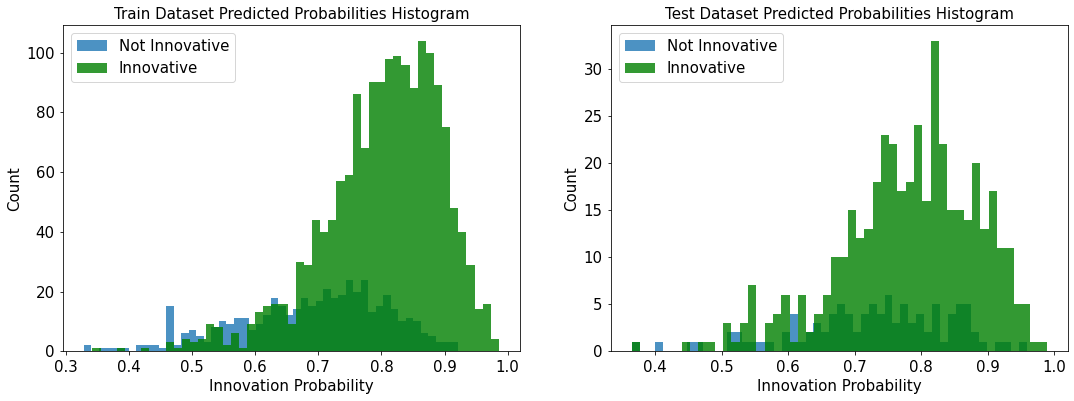

In [8]:
# Logistic Regression Classifier -> TF-IDF 
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.9892221180880975
Test Accuracy:       0.7621722846441947
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.35      0.06      0.10       121
           1       0.78      0.97      0.86       413

    accuracy                           0.76       534
   macro avg       0.56      0.51      0.48       534
weighted avg       0.68      0.76      0.69       534



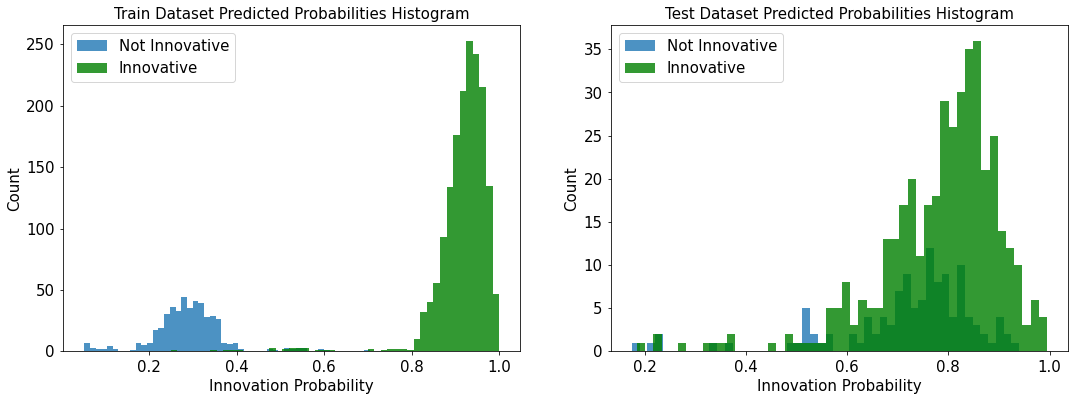

In [21]:
#Random Forest Classifier -> TF-IDF 
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 200, max_depth = None, oob_score = False, criterion = 'entropy', min_samples_split = 2, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

In [326]:
# Only TF-IDF (Oversampling = True)
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(full_dataset, 22494, 0.8, 400, True, 1700)

['aanbod', 'aanpak', 'accessoires', 'account', 'activiteiten', 'adres', 'advies', 'afspraak', 'afval', 'air', 'algemene', 'alle', 'alleen', 'aluminium', 'antwerpen', 'app', 'applications', 'art', 'assortiment', 'automotive', 'back', 'basis', 'bedrijf', 'bedrijven', 'bekijk', 'belgi', 'belgium', 'bent', 'best', 'beste', 'bezoek', 'bieden', 'biedt', 'binnen', 'blijven', 'blog', 'bouw', 'brand', 'brands', 'browser', 'btw', 'building', 'business', 'bvba', 'care', 'careers', 'case', 'center', 'chain', 'chemicals', 'close', 'cloud', 'code', 'company', 'conditions', 'construction', 'contact', 'contacteer', 'containers', 'content', 'control', 'cookie', 'cookies', 'copyright', 'corporate', 'covid', 'customer', 'customers', 'dag', 'dankzij', 'data', 'day', 'design', 'details', 'deutsch', 'development', 'diensten', 'digital', 'digitale', 'disclaimer', 'discover', 'diverse', 'download', 'downloads', 'duurzaam', 'duurzaamheid', 'duurzame', 'eerste', 'eigen', 'elk', 'elke', 'email', 'endisplayinsect

Training Accuracy:   0.7966260543580131
Test Accuracy:       0.7621722846441947
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.33      0.02      0.03       125
           1       0.77      0.99      0.86       409

    accuracy                           0.76       534
   macro avg       0.55      0.50      0.45       534
weighted avg       0.67      0.76      0.67       534



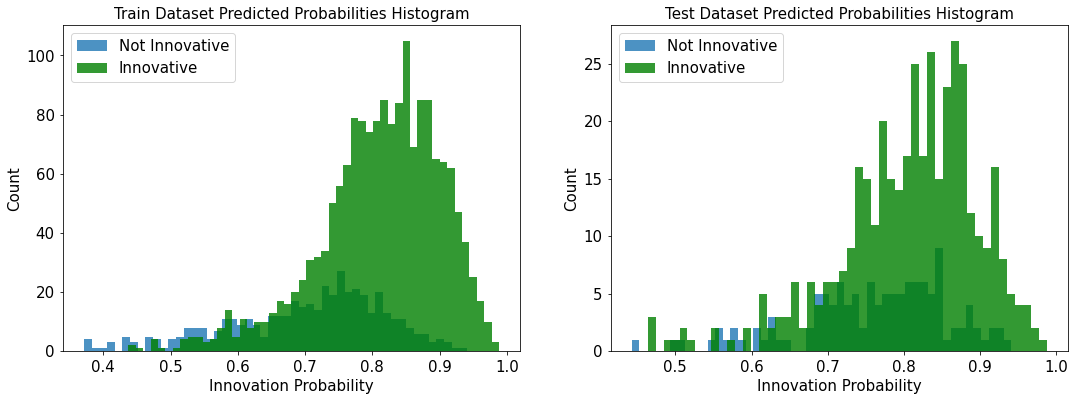

In [328]:
# Logistic Regression Classifier -> TF-IDF 
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.9906279287722587
Test Accuracy:       0.7471910112359551
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.22      0.03      0.06       125
           1       0.77      0.97      0.85       409

    accuracy                           0.75       534
   macro avg       0.49      0.50      0.45       534
weighted avg       0.64      0.75      0.67       534



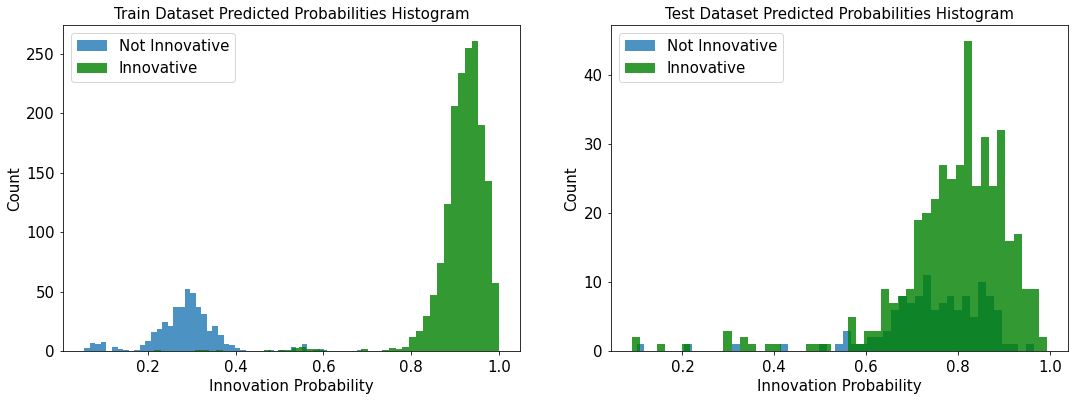

In [329]:
#Random Forest Classifier -> TF-IDF 
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 200, max_depth = None, oob_score = False, criterion = 'entropy', min_samples_split = 2, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

In [27]:
# Train Word-Embeddings + Combine with TF-IDF (Oversampling = False)
we_dataset = train_word_embeddings(full_dataset, 200, 5, 3, 2)
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(we_dataset, 22494, 0.80, 400, embeddings = True)

['aanbod', 'aanpak', 'accessoires', 'account', 'activiteiten', 'adres', 'advies', 'afspraak', 'air', 'algemene', 'alle', 'alleen', 'aluminium', 'antwerpen', 'applications', 'art', 'assortiment', 'automation', 'automotive', 'back', 'basis', 'bedrijf', 'bedrijven', 'bekijk', 'belgi', 'belgium', 'bent', 'best', 'beste', 'bezoek', 'bieden', 'biedt', 'binnen', 'blijven', 'blog', 'bouw', 'brand', 'brands', 'browse', 'browser', 'btw', 'building', 'business', 'bvba', 'care', 'careers', 'case', 'center', 'chain', 'choose', 'close', 'cloud', 'code', 'company', 'conditions', 'construction', 'contact', 'contacteer', 'containers', 'content', 'control', 'cookie', 'cookies', 'copyright', 'corporate', 'covid', 'customer', 'customers', 'dag', 'dankzij', 'data', 'design', 'details', 'deuren', 'deutsch', 'development', 'diensten', 'digital', 'digitale', 'disclaimer', 'discover', 'diverse', 'download', 'downloads', 'duurzaam', 'duurzaamheid', 'duurzame', 'eerste', 'eigen', 'elk', 'elke', 'email', 'endispl

Training Accuracy:   0.795688847235239
Test Accuracy:       0.7715355805243446
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.45      0.04      0.08       121
           1       0.78      0.99      0.87       413

    accuracy                           0.77       534
   macro avg       0.62      0.51      0.47       534
weighted avg       0.70      0.77      0.69       534



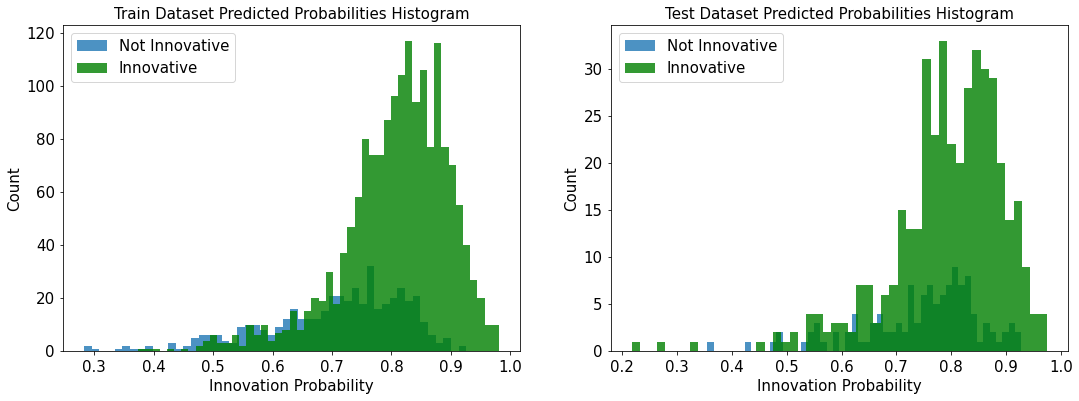

In [338]:
# Logistic Regression Classifier -> TF-IDF + Word Embeddings 
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.9896907216494846
Test Accuracy:       0.7659176029962547
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.39      0.06      0.10       121
           1       0.78      0.97      0.87       413

    accuracy                           0.77       534
   macro avg       0.58      0.52      0.48       534
weighted avg       0.69      0.77      0.69       534



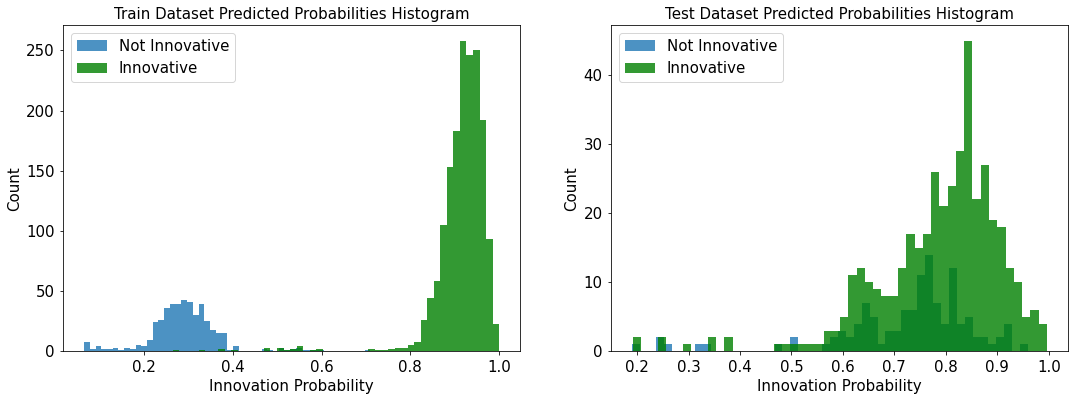

In [339]:
#Random Forest Classifier -> TF-IDF + Word Embeddings
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 200, max_depth = None, oob_score = False, criterion = 'entropy', min_samples_split = 2, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

In [34]:
# Train Word-Embeddings + Combine with TF-IDF (Oversampling = True)
we_dataset = train_word_embeddings(full_dataset, 200, 5, 3, 2)
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(we_dataset, 22494, 0.80, 400, True, 1700, embeddings = True)

['aanbod', 'aanpak', 'accessoires', 'account', 'activiteiten', 'adres', 'advies', 'afspraak', 'afval', 'air', 'algemene', 'alle', 'alleen', 'aluminium', 'antwerpen', 'app', 'applications', 'art', 'assortiment', 'automotive', 'back', 'basis', 'bedrijf', 'bedrijven', 'bekijk', 'belgi', 'belgium', 'bent', 'best', 'beste', 'bezoek', 'bieden', 'biedt', 'binnen', 'blijven', 'blog', 'bouw', 'brand', 'brands', 'browser', 'btw', 'building', 'business', 'bvba', 'care', 'careers', 'case', 'center', 'chain', 'chemicals', 'close', 'cloud', 'code', 'company', 'conditions', 'construction', 'contact', 'contacteer', 'containers', 'content', 'control', 'cookie', 'cookies', 'copyright', 'corporate', 'covid', 'customer', 'customers', 'dag', 'dankzij', 'data', 'day', 'design', 'details', 'deutsch', 'development', 'diensten', 'digital', 'digitale', 'disclaimer', 'discover', 'diverse', 'download', 'downloads', 'duurzaam', 'duurzaamheid', 'duurzame', 'eerste', 'eigen', 'elk', 'elke', 'email', 'endisplayinsect

Training Accuracy:   0.8706654170571696
Test Accuracy:       0.8913857677902621
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.94      0.46      0.62       102
           1       0.89      0.99      0.94       432

    accuracy                           0.89       534
   macro avg       0.91      0.73      0.78       534
weighted avg       0.90      0.89      0.88       534



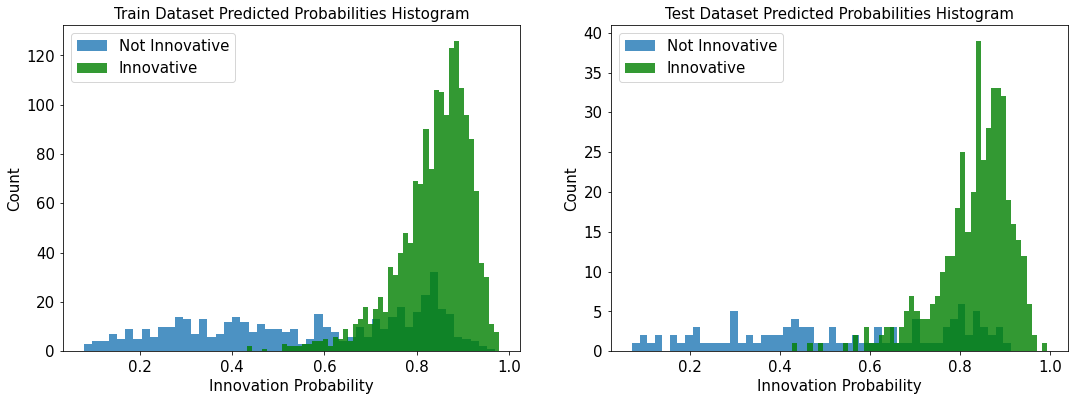

In [9]:
# Logistic Regression Classifier -> TF-IDF + Word Embeddings
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.9948453608247423
Test Accuracy:       0.8764044943820225
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.90      0.48      0.63       116
           1       0.87      0.99      0.93       418

    accuracy                           0.88       534
   macro avg       0.89      0.73      0.78       534
weighted avg       0.88      0.88      0.86       534



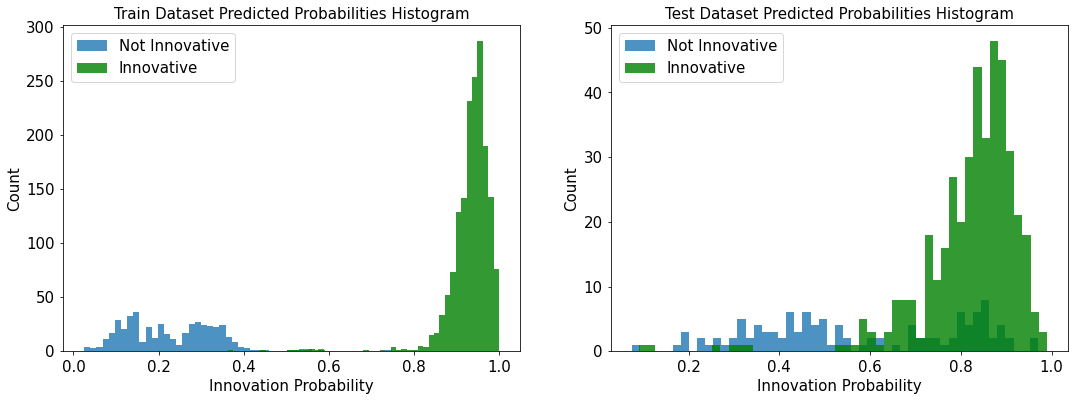

In [35]:
#Random Forest Classifier -> TF-IDF + Word Embeddings
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 200, max_depth = None, oob_score = False, criterion = 'entropy', min_samples_split = 2, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.9925023430178069
Test Accuracy:       0.9119850187265918
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.97      0.56      0.71       102
           1       0.91      1.00      0.95       432

    accuracy                           0.91       534
   macro avg       0.94      0.78      0.83       534
weighted avg       0.92      0.91      0.90       534



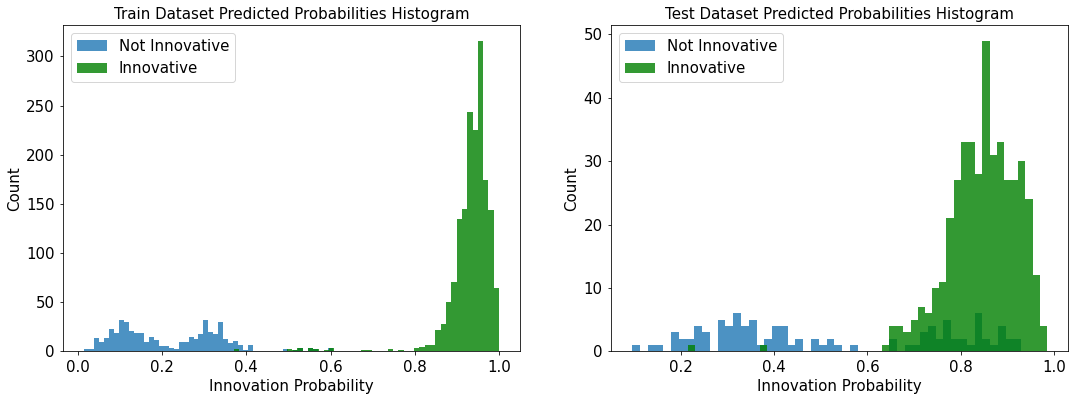

In [10]:
#Random Forest Classifier -> TF-IDF + Word Embeddings
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 200, max_depth = None, oob_score = False, criterion = 'entropy', min_samples_split = 2, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.6447985004686035
Test Accuracy:       0.6479400749063671
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.32      0.74      0.44       102
           1       0.91      0.63      0.74       432

    accuracy                           0.65       534
   macro avg       0.61      0.68      0.59       534
weighted avg       0.80      0.65      0.69       534



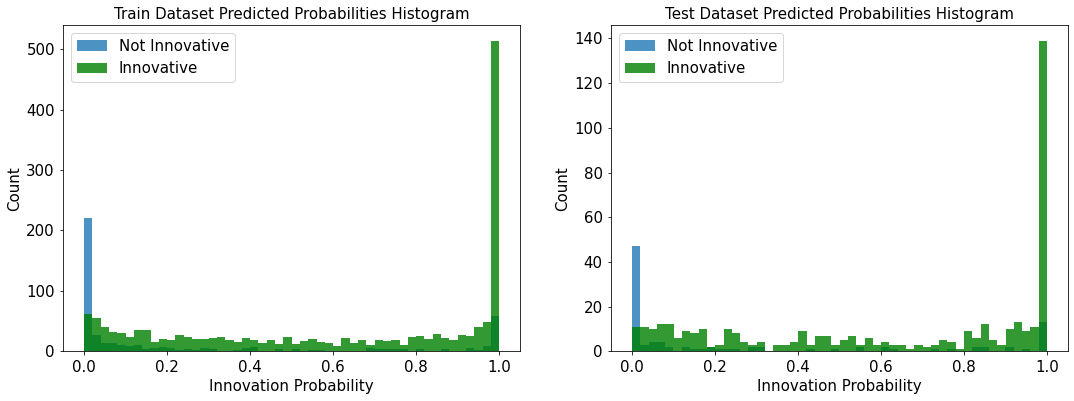

In [11]:
# Bernoulli Naive Bayes Trial ~ Binarize = True
gnb = BernoulliNB(fit_prior=True)
model = gnb.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

In [346]:
#Combine with Word Embeddings with Bag of Words (Oversampling = True)
Train_X, train_y, Test_X, test_y = BOW_prebuild_sets(we_dataset, 22494, 0.8, 400, True, 1700, embeddings=True , binary=True)

['aanbod', 'aanpak', 'aanvragen', 'account', 'actief', 'activiteiten', 'adres', 'advies', 'afspraak', 'algemene', 'alle', 'alleen', 'antwerpen', 'applications', 'assortiment', 'automotive', 'basis', 'bedrijf', 'bedrijven', 'bekijk', 'bel', 'belgi', 'belgische', 'belgium', 'bent', 'best', 'beste', 'beter', 'betrouwbare', 'bezoek', 'bieden', 'biedt', 'binnen', 'blijf', 'blijven', 'blog', 'bouw', 'bouwen', 'browser', 'btw', 'business', 'bvba', 'care', 'careers', 'center', 'chain', 'close', 'company', 'complete', 'conditions', 'contact', 'contacteer', 'content', 'cookie', 'cookies', 'copyright', 'coronavirus', 'corporate', 'covid', 'customer', 'customers', 'daarom', 'dag', 'dankzij', 'data', 'deel', 'design', 'deutsch', 'development', 'dienst', 'diensten', 'digital', 'digitale', 'disclaimer', 'discover', 'diverse', 'download', 'downloads', 'duurzaam', 'duurzaamheid', 'duurzame', 'eerste', 'eigen', 'elk', 'elke', 'email', 'engineering', 'english', 'enkel', 'enkele', 'equipment', 'ervaring',

Training Accuracy:   0.8861293345829429
Test Accuracy:       0.7921348314606742
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.63      0.27      0.38       125
           1       0.81      0.95      0.88       409

    accuracy                           0.79       534
   macro avg       0.72      0.61      0.63       534
weighted avg       0.77      0.79      0.76       534



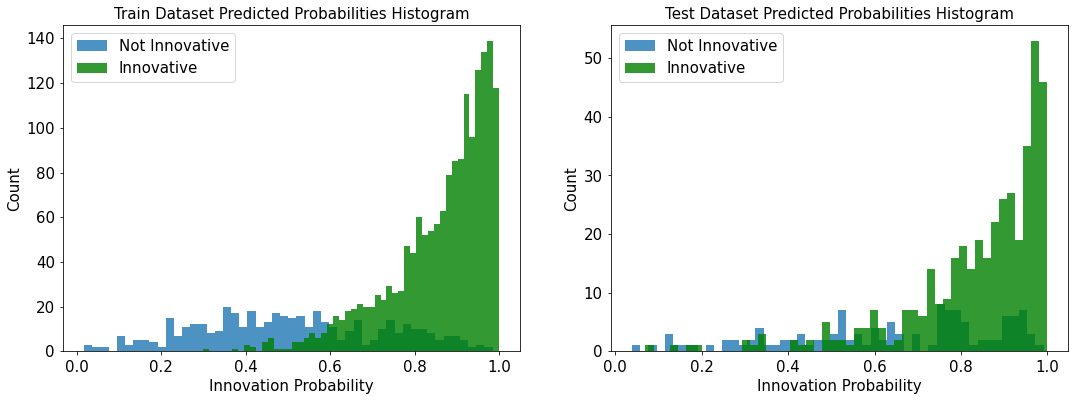

In [347]:
# Logistic Regression Classifier -> BoW + Word Embeddings
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.9943767572633552
Test Accuracy:       0.8707865168539326
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.88      0.52      0.65       125
           1       0.87      0.98      0.92       409

    accuracy                           0.87       534
   macro avg       0.87      0.75      0.79       534
weighted avg       0.87      0.87      0.86       534



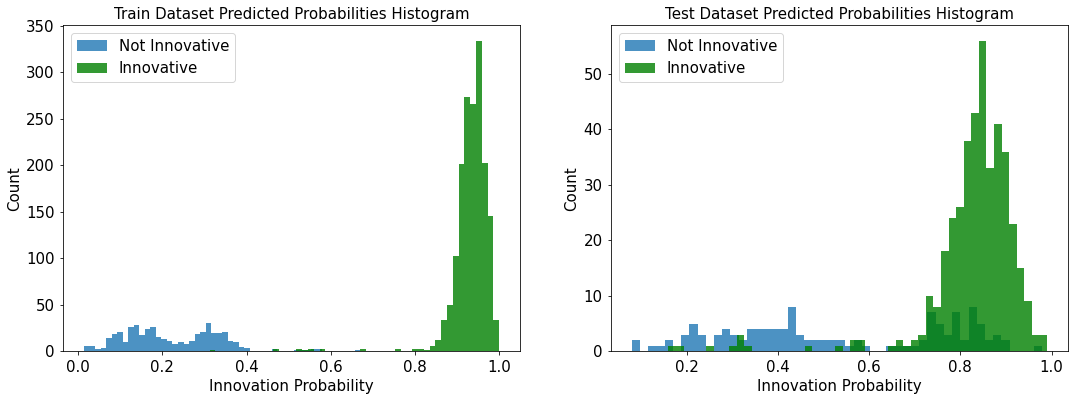

In [348]:
#Random Forest Classifier -> BoW + Word Embeddings
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 200, max_depth = None, oob_score = False, criterion = 'entropy', min_samples_split = 2, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

In [ ]:
#Word Embeddings Dataset Impact 

random.seed(22494)
random_seeds_list_5 = [random.randint(0,100000) for i in range(5)]
fraction_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
average_test_accuracy = []
c = 0

model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)

for i in fraction_list:
    temp_df = full_dataset.sample(frac=i, random_state = 22494)
    we_dataset = train_word_embeddings(temp_df, 200, 5, 3, 2)
    test_acc = []
    merged = full_dataset.merge(temp_df['doc_vector'], left_index=True, right_index=True)
    for j in random_seeds_list_5:
        Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(merged, j, 0.80, 400, True, 1700, embeddings = True)
        model.fit(Train_X, train_y)
        test_acc.append(accuracy_score(test_y, model.predict(Test_X)))
    average_test_accuracy.append(sum(test_acc)/len(test_acc))
    c += 1
    print('Iteration ', c, ' is finished -> Average test accuracy: ', sum(test_acc)/len(test_acc))

In [92]:
average_test_accuracy

[0.7904761904761906,
 0.7910913140311804,
 0.7979550102249489,
 0.815625,
 0.843939393939394,
 0.8853932584269663]

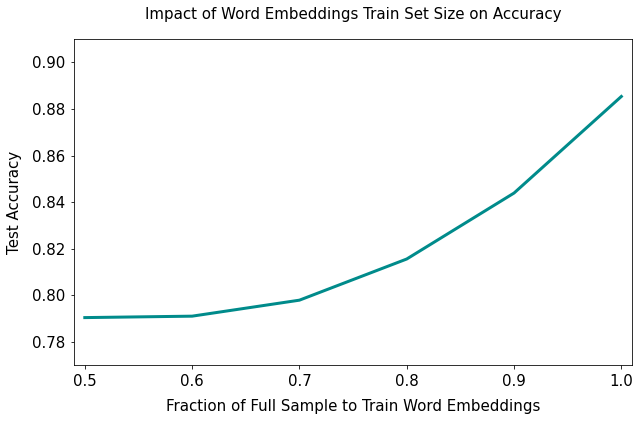

In [91]:
#Plot
plt.figure(figsize=(10,6))
plt.plot(fraction_list,average_test_accuracy, linewidth = 3, c = 'darkcyan')
plt.title('Impact of Word Embeddings Train Set Size on Accuracy', fontsize=15, pad=20)
plt.xlim(0.49,1.01)
plt.ylim(0.77,0.91)
plt.xlabel('Fraction of Full Sample to Train Word Embeddings', fontsize=15, labelpad=10)
plt.ylabel('Test Accuracy', fontsize=15, labelpad=10)
plt.tick_params(axis='both', labelsize=15, pad=5)

In [44]:
coefs = pd.DataFrame(zip(Train_X.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])
coefs = coefs[coefs['features'] != 'doc_vector']
negatives = coefs.sort_values(by=['coef'], ascending=True).head(20).reset_index(drop=True)
positives = coefs.sort_values(by=['coef'], ascending=False).head(20).reset_index(drop=True)
table_f = negatives.merge(positives, right_index=True, left_index=True)
table_f.columns = ['Negative Words', 'Coefficient', 'Positive Words', 'Coefficient']
table_f

,Negative Words,Coefficient,Positive Words,Coefficient
0,supply,-2.411440,applications,2.814983
1,staan,-2.364553,research,2.654634
2,ervaring,-2.314826,design,2.187716
3,grote,-2.187392,data,2.031878
4,industrile,-1.954334,technology,1.806105
5,offerte,-1.888635,innovation,1.772671
6,transport,-1.816360,policy,1.721708
7,wij,-1.755766,jobs,1.525152
8,binnen,-1.655917,development,1.519912
9,klant,-1.620647,news,1.514437


In [29]:
#Confidence intervals for Logistic Regression
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
test_accuracy_list = []

for i in random_seeds_list:
    Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(we_dataset, i, 0.80, 400, True, 1700, embeddings = True, verbose = False)
    model.fit(Train_X, train_y)
    test_accuracy_list.append(accuracy_score(test_y, model.predict(Test_X)))
    
print('Test accuracy of 100 Random Train-Test Splits: \n')     
print('95% Lower Bound: '.ljust(25), st.t.interval(0.95, len(a)-1, loc=np.mean(test_accuracy_list), scale=np.std(test_accuracy_list))[0])
print('Minimum Test Accuracy: '.ljust(25), np.min(test_accuracy_list))
print('Mean Test Accuracy: '.ljust(25), np.mean(test_accuracy_list))
print('Maximum Test Accuracy: '.ljust(25), np.max(test_accuracy_list))
print('95% Upper Bound: '.ljust(25), st.t.interval(0.95, len(a)-1, loc=np.mean(test_accuracy_list), scale=np.std(test_accuracy_list))[1])

Test accuracy of 100 Random Train-Test Splits: 

95% Lower Bound:          0.8498833407903208
Minimum Test Accuracy:    0.8707865168539326
Mean Test Accuracy:       0.8994569288389515
Maximum Test Accuracy:    0.9250936329588015
95% Upper Bound:          0.9490305168875821


In [30]:
#Confidence intervals for Random Forests 
model = RandomForestClassifier(random_state = 22494, n_estimators = 200, max_depth = None, oob_score = False, criterion = 'entropy', min_samples_split = 2, max_samples = 2000)
test_accuracy_list = []

for i in random_seeds_list:
    Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(we_dataset, i, 0.80, 400, True, 1700, embeddings = True, verbose = False)
    model.fit(Train_X, train_y)
    test_accuracy_list.append(accuracy_score(test_y, model.predict(Test_X)))
    
print('Test accuracy of 100 Random Train-Test Splits: \n')     
print('95% Lower Bound: '.ljust(25), st.t.interval(0.95, len(a)-1, loc=np.mean(test_accuracy_list), scale=np.std(test_accuracy_list))[0])
print('Minimum Test Accuracy: '.ljust(25), np.min(test_accuracy_list))
print('Mean Test Accuracy: '.ljust(25), np.mean(test_accuracy_list))
print('Maximum Test Accuracy: '.ljust(25), np.max(test_accuracy_list))
print('95% Upper Bound: '.ljust(25), st.t.interval(0.95, len(a)-1, loc=np.mean(test_accuracy_list), scale=np.std(test_accuracy_list))[1])

Test accuracy of 100 Random Train-Test Splits: 

95% Lower Bound:          0.8416581240968263
Minimum Test Accuracy:    0.8632958801498127
Mean Test Accuracy:       0.8940262172284646
Maximum Test Accuracy:    0.9213483146067416
95% Upper Bound:          0.946394310360103


In [45]:
#Hyper-Parameter Search for Logistic Regression

#Create 10-Fold cross validation set
kfold = KFold(n_splits=10)

#Concat the shuffled sets
full_X = pd.concat([Train_X, Test_X])
full_y = pd.concat([train_y, test_y])

#Form the parameter search space
param_space = [{'C':np.logspace(-3,3,7), 'penalty':['l1','l2'], 'solver':['liblinear']},
               {'C':np.logspace(-3,3,7), 'penalty':['elasticnet'], 'solver':['saga'], 'l1_ratio': np.linspace(0.1,0.9,5)}]

#Start the grid search
model = LogisticRegression()
grid = GridSearchCV(model, param_grid=param_space, cv=kfold, n_jobs=3)
best_model = grid.fit(full_X, full_y)
print(best_model.best_estimator_.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [47]:
#Hyper-Parameter Search for Random Forests

#Create 10-Fold cross validation set
kfold = KFold(n_splits=10)

#Concat the shuffled sets
full_X = pd.concat([Train_X, Test_X])
full_y = pd.concat([train_y, test_y])

#Form the parameter search space
param_space = {'bootstrap': [True, False],
               'criterion': ['entropy', 'gini'],
               'max_depth': [10, 100, None],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5],
               'n_estimators': [100, 200, 500, 1000, 1500]}

#Start the grid search
model = RandomForestClassifier()
grid = GridSearchCV(model, param_grid=param_space, cv=kfold, n_jobs=3, verbose = 10)
best_model = grid.fit(full_X, full_y)
print(best_model.best_estimator_.get_params())

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   23.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   25.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   28.0s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   33.9s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   47.0s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed:  3.4min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  6.3min
[Parallel(

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [33]:
#Save embeddings for reproduction

#we_dataset.to_pickle('w2v_embed.pkl')
we_dataset = pd.read_pickle('w2v_embed.pkl')

In [6]:
#Add language as a predictor

language_list = []
cursor = FBW.aql.execute('FOR doc IN Businesses RETURN doc', ttl=5000)
for document in cursor:
    if(("Final_Text_IR04" in document) and ("Innovation" in document)):
        if(document["Language"] == "nl"):
            language_list.append(1)
        else:
            language_list.append(0)

full_dataset["w_language"] = language_list

In [14]:
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(we_dataset, 22494, 0.80, 400, True, 1700, embeddings = True, language = True)

['aanbod', 'aanpak', 'accessoires', 'account', 'activiteiten', 'adres', 'advies', 'afspraak', 'afval', 'air', 'algemene', 'alle', 'alleen', 'aluminium', 'antwerpen', 'app', 'applications', 'art', 'assortiment', 'automotive', 'back', 'basis', 'bedrijf', 'bedrijven', 'bekijk', 'belgi', 'belgium', 'bent', 'best', 'beste', 'bezoek', 'bieden', 'biedt', 'binnen', 'blijven', 'blog', 'bouw', 'brand', 'brands', 'browser', 'btw', 'building', 'business', 'bvba', 'care', 'careers', 'case', 'center', 'chain', 'chemicals', 'close', 'cloud', 'code', 'company', 'conditions', 'construction', 'contact', 'contacteer', 'containers', 'content', 'control', 'cookie', 'cookies', 'copyright', 'corporate', 'covid', 'customer', 'customers', 'dag', 'dankzij', 'data', 'day', 'design', 'details', 'deutsch', 'development', 'diensten', 'digital', 'digitale', 'disclaimer', 'discover', 'diverse', 'download', 'downloads', 'duurzaam', 'duurzaamheid', 'duurzame', 'eerste', 'eigen', 'elk', 'elke', 'email', 'endisplayinsect

In [38]:
we_dataset = train_word_embeddings(full_dataset, 200, 5, 3, 2)

In [39]:
language_list = []
cursor = FBW.aql.execute('FOR doc IN Businesses RETURN doc', ttl=5000)
for document in cursor:
    if(("Final_Text_IR04" in document) and ("Innovation" in document)):
        if(document["Language"] == "nl"):
            language_list.append(1)
        else:
            language_list.append(0)

we_dataset["w_language"] = language_list
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets(we_dataset, 22494, 0.80, 300, True, 1700, embeddings = True, language = True, verbose = False)

Training Accuracy:   0.8753514526710403
Test Accuracy:       0.8614232209737828
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.81      0.47      0.60       116
           1       0.87      0.97      0.92       418

    accuracy                           0.86       534
   macro avg       0.84      0.72      0.76       534
weighted avg       0.86      0.86      0.85       534



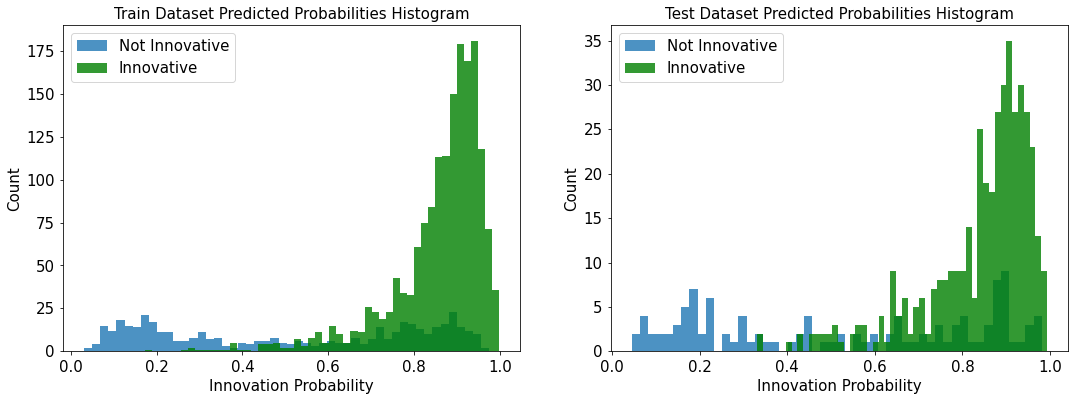

In [26]:
# Logistic Regression Classifier -> TF-IDF + Word Embeddings
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

In [41]:
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
coefs = pd.DataFrame(zip(Train_X.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])
coefs = coefs[coefs['features'] != 'doc_vector']
negatives = coefs.sort_values(by=['coef'], ascending=True).head(20).reset_index(drop=True)
positives = coefs.sort_values(by=['coef'], ascending=False).head(20).reset_index(drop=True)
table_f = negatives.merge(positives, right_index=True, left_index=True)
table_f.columns = ['Negative Words', 'Coefficient', 'Positive Words', 'Coefficient']
table_f

,Negative Words,Coefficient,Positive Words,Coefficient
0,offerte,-3.485245,applications,2.700980
1,diensten,-1.659226,design,2.545668
2,onze,-1.414276,development,2.460443
3,bezoek,-1.392263,software,1.651324
4,wij,-1.323372,health,1.576441
5,staan,-1.320520,high,1.544302
6,transport,-1.263706,systems,1.497955
7,email,-1.176658,events,1.383302
8,industrile,-1.150763,experience,1.290678
9,supply,-1.133433,technology,1.232342


In [40]:
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(pd.concat([Train_X, Test_X]), pd.concat([train_y, test_y]))
coefs = pd.DataFrame(zip(Train_X.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])
coefs = coefs[coefs['features'] != 'doc_vector']
negatives = coefs.sort_values(by=['coef'], ascending=True).head(20).reset_index(drop=True)
positives = coefs.sort_values(by=['coef'], ascending=False).head(20).reset_index(drop=True)
table_f = negatives.merge(positives, right_index=True, left_index=True)
table_f.columns = ['Negative Words', 'Coefficient', 'Positive Words', 'Coefficient']
table_f

,Negative Words,Coefficient,Positive Words,Coefficient
0,offerte,-3.125190,applications,3.888763
1,diensten,-1.609509,development,2.800297
2,grote,-1.599405,health,2.529904
3,industrile,-1.482891,design,2.526723
4,transport,-1.411630,high,1.910126
5,bezoek,-1.219461,software,1.885947
6,ervaring,-1.200515,technology,1.881516
7,supply,-1.174373,research,1.840035
8,onze,-1.158144,jobs,1.729377
9,afspraak,-1.153477,time,1.571779


In [22]:
coefs = pd.DataFrame(zip(Train_X.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])
coefs = coefs[coefs['features'] != 'doc_vector']
negatives = coefs.sort_values(by=['coef'], ascending=True).head(20).reset_index(drop=True)
positives = coefs.sort_values(by=['coef'], ascending=False).head(20).reset_index(drop=True)
table_f = negatives.merge(positives, right_index=True, left_index=True)
table_f.columns = ['Negative Words', 'Coefficient', 'Positive Words', 'Coefficient']
table_f

,Negative Words,Coefficient,Positive Words,Coefficient
0,offerte,-2.624502,development,3.886875
1,supply,-2.485745,applications,3.498497
2,industrile,-1.801293,w_language,3.383978
3,bezoek,-1.535550,design,2.646224
4,sinds,-1.425728,language,2.516790
5,wij,-1.344018,technology,2.345184
6,diensten,-1.292598,products,1.982570
7,onze,-1.280597,disclaimer,1.966982
8,transport,-1.234284,news,1.902784
9,bedrijven,-1.167331,systems,1.890896


Training Accuracy:   0.8683223992502344
Test Accuracy:       0.897003745318352
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.96      0.48      0.64       102
           1       0.89      1.00      0.94       432

    accuracy                           0.90       534
   macro avg       0.93      0.74      0.79       534
weighted avg       0.90      0.90      0.88       534



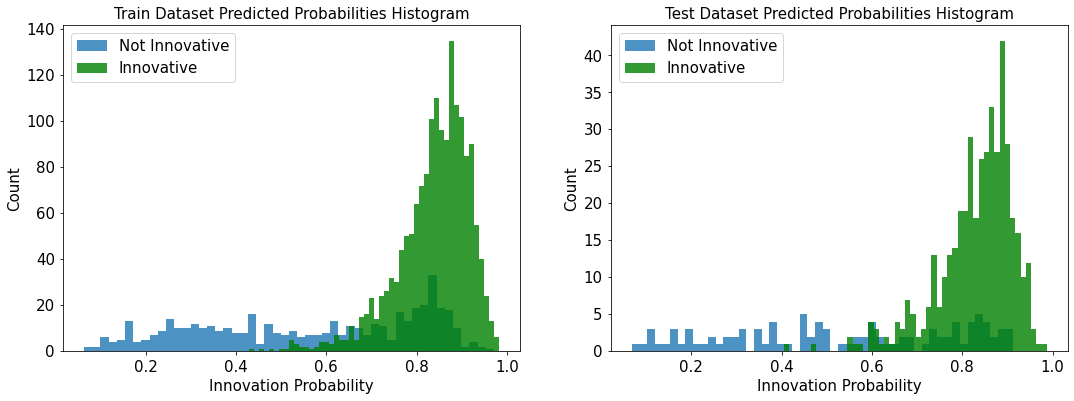

In [92]:
# Logistic Regression Classifier -> TF-IDF + W2V + Language Code
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

In [93]:
coefs = pd.DataFrame(zip(Train_X.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])
coefs = coefs[coefs['features'] != 'doc_vector']
negatives = coefs.sort_values(by=['coef'], ascending=True).head(20).reset_index(drop=True)
positives = coefs.sort_values(by=['coef'], ascending=False).head(20).reset_index(drop=True)
table_f = negatives.merge(positives, right_index=True, left_index=True)
table_f.columns = ['Negative Words', 'Coefficient', 'Positive Words', 'Coefficient']
table_f

,Negative Words,Coefficient,Positive Words,Coefficient
0,bieden,-2.117822,applications,3.062528
1,grote,-2.111511,jobs,1.973444
2,wij,-2.065187,innovation,1.738151
3,ervaring,-1.854440,design,1.579321
4,klant,-1.762674,research,1.577104
5,bezoek,-1.736255,development,1.567390
6,kunt,-1.254073,english,1.285632
7,binnen,-1.188756,products,1.150197
8,industrile,-1.109937,technology,1.113349
9,supply,-1.100523,events,1.095757


In [38]:
#Doc2Vec
de_dataset = train_doc_embeddings(full_dataset,50,5,10,3)
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets_d2v(de_dataset, 22494, 0.80, 300, True, 1700, embeddings = False, language = True, d2v = True, verbose = False)

In [9]:
#Doc2Vec
de_dataset = train_doc_embeddings(full_dataset,50,5,10,3)
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets_d2v(de_dataset, 22494, 0.80, 300, True, 1700, embeddings = False, language = True, d2v = True, verbose = False)

In [14]:
Train_X['w_language'].value_counts()

1    1529
0     605
Name: w_language, dtype: int64

Training Accuracy:   0.8842549203373946
Test Accuracy:       0.897003745318352
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       109
           1       0.91      0.97      0.94       425

    accuracy                           0.90       534
   macro avg       0.88      0.79      0.82       534
weighted avg       0.89      0.90      0.89       534



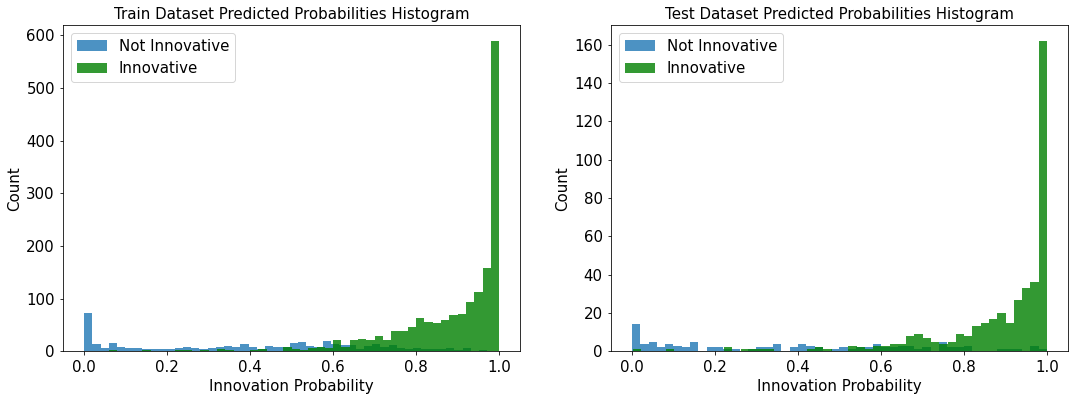

In [16]:
# Logistic Regression Classifier -> TF-IDF + Doc2Vec + Language Code 
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.895032802249297
Test Accuracy:       0.8576779026217228
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.78      0.48      0.60       116
           1       0.87      0.96      0.91       418

    accuracy                           0.86       534
   macro avg       0.82      0.72      0.75       534
weighted avg       0.85      0.86      0.84       534



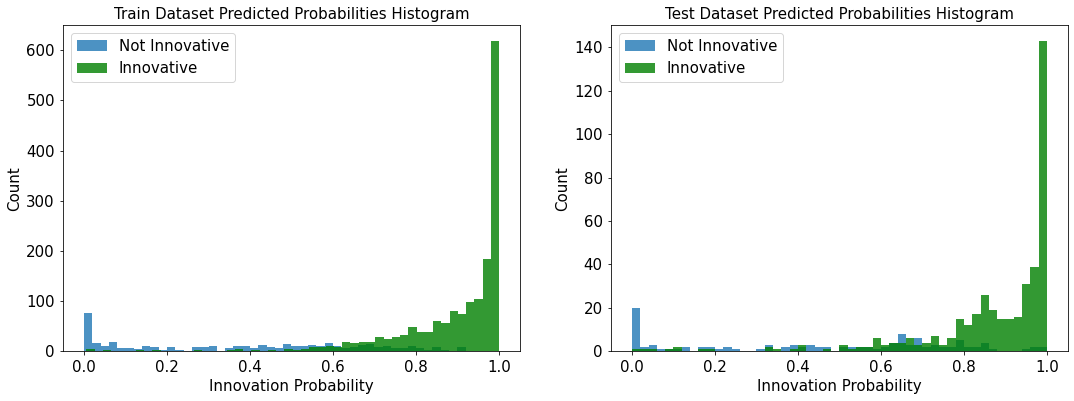

In [17]:
# Logistic Regression Classifier -> TF-IDF + Doc2Vec + Language Code - No Oversampling
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets_d2v(de_dataset, 22494, 0.80, 300, False, 0, embeddings = False, language = True, d2v = True, verbose = False)
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

Training Accuracy:   0.9686035613870665
Test Accuracy:       0.8445692883895131
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.88      0.28      0.42       109
           1       0.84      0.99      0.91       425

    accuracy                           0.84       534
   macro avg       0.86      0.63      0.66       534
weighted avg       0.85      0.84      0.81       534



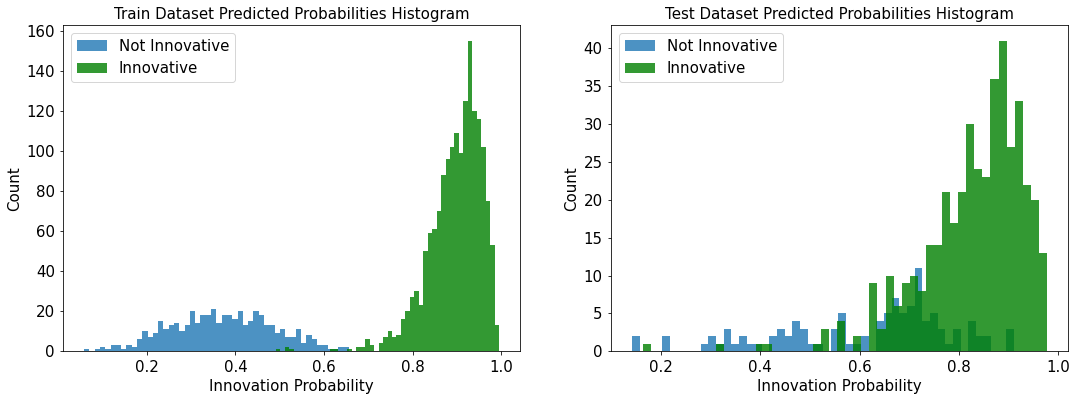

In [33]:
# Random Forest Classifier -> TF-IDF + Doc2Vec + Language Code
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets_d2v(de_dataset, 22494, 0.80, 300, False, 0, embeddings = False, language = True, d2v = True, verbose = False)
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 300, max_depth = 15, oob_score = False, criterion = 'entropy', min_samples_split = 8, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show()

Training Accuracy:   0.9686035613870665
Test Accuracy:       0.8108614232209738
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.73      0.21      0.32       116
           1       0.82      0.98      0.89       418

    accuracy                           0.81       534
   macro avg       0.77      0.59      0.61       534
weighted avg       0.80      0.81      0.77       534



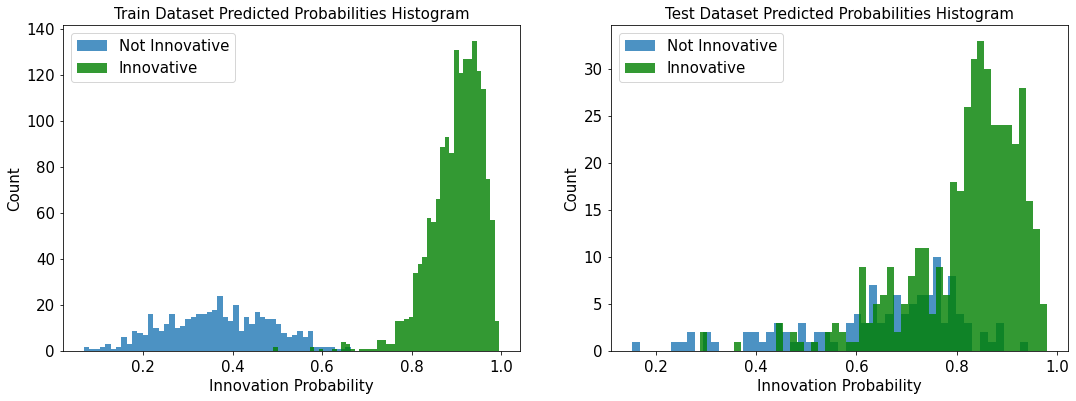

In [32]:
# Random Forest Classifier -> TF-IDF + Doc2Vec + Language Code - No Oversampling
Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets_d2v(de_dataset, 22494, 0.80, 300, False, 0, embeddings = False, language = True, d2v = True, verbose = False)
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 300, max_depth = 15, oob_score = False, criterion = 'entropy', min_samples_split = 8, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show()

In [13]:
pickle.dump(model, open('LR-D2V-IR01.pkl', 'wb'))

Training Accuracy:   0.8884723523898782
Test Accuracy:       0.8951310861423221
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.87      0.53      0.66       102
           1       0.90      0.98      0.94       432

    accuracy                           0.90       534
   macro avg       0.88      0.76      0.80       534
weighted avg       0.89      0.90      0.88       534



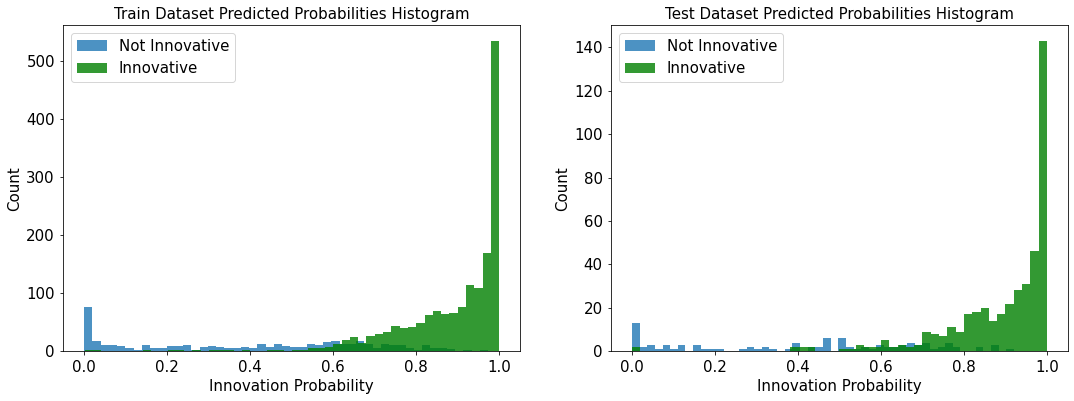

In [214]:
# Logistic Regression Classifier -> TF-IDF + Doc2Vec + Language Code 
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X, train_y)
score = model.score(Train_X, train_y)
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

In [215]:
coefs = pd.DataFrame(zip(Train_X.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])
enum_list = list(range(50))
for i in range(len(coefs)):
    if(coefs['features'][i] in enum_list):
        coefs = coefs.drop(index=i)
negatives = coefs.sort_values(by=['coef'], ascending=True).head(20).reset_index(drop=True)
positives = coefs.sort_values(by=['coef'], ascending=False).head(20).reset_index(drop=True)
table_f = negatives.merge(positives, right_index=True, left_index=True)
table_f.columns = ['Negative Words', 'Coefficient', 'Positive Words', 'Coefficient']
table_f

,Negative Words,Coefficient,Positive Words,Coefficient
0,learn,-1.205689,terug,1.532020
1,klant,-1.186723,info,1.119241
2,binnen,-0.818478,packaging,0.866291
3,kennis,-0.750179,maat,0.778502
4,vanaf,-0.712604,jobs,0.572850
5,home,-0.624326,news,0.553241
6,maken,-0.565862,onderhoud,0.508575
7,digital,-0.509912,lees,0.499780
8,onze,-0.504747,goed,0.459399
9,ervaring,-0.476110,ontdek,0.335634


In [16]:
coefs = pd.DataFrame(zip(Train_X.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])
coefs[coefs['features'] == "w_language"]

,features,coef
1,w_language,-0.169937


In [257]:
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
scores = cross_val_score(model, pd.concat([Train_X, Test_X]), pd.concat([train_y,test_y]), cv= kfold)

array([0.85018727, 0.87640449, 0.90074906, 0.85928705, 0.89493433])

Training Accuracy:   0.9686035613870665
Test Accuracy:       0.848314606741573
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.96      0.22      0.35       102
           1       0.84      1.00      0.91       432

    accuracy                           0.85       534
   macro avg       0.90      0.61      0.63       534
weighted avg       0.87      0.85      0.81       534



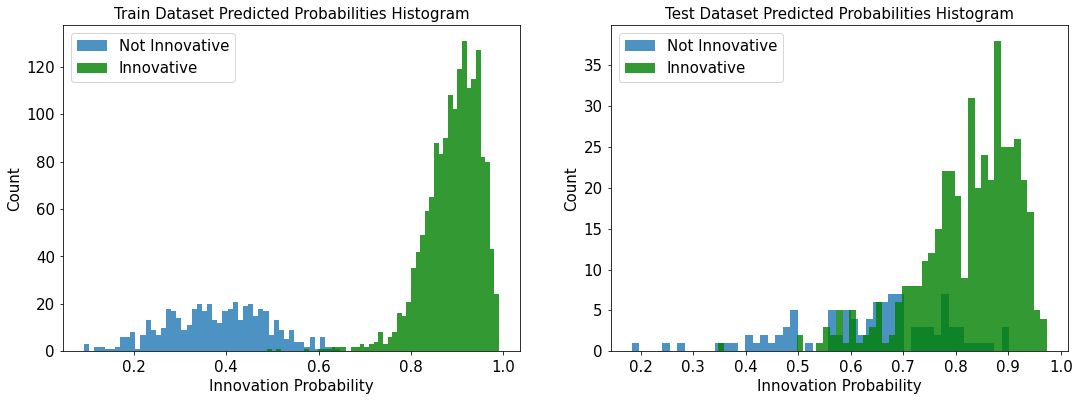

In [259]:
#Random Forest Classifier -> BoW + Word Embeddings
RFC = RandomForestClassifier(random_state = 22494, n_estimators = 300, max_depth = 15, oob_score = False, criterion = 'entropy', min_samples_split = 8, max_samples = 2000)
model = RFC.fit(Train_X, train_y)
print("Training Accuracy: ".ljust(20), accuracy_score(train_y, model.predict(Train_X)))
print("Test Accuracy: ".ljust(20), accuracy_score(test_y, model.predict(Test_X)))
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, model.predict(Test_X)))
train_pred = model.predict_proba(Train_X)[:,1]
test_pred = model.predict_proba(Test_X)[:,1]

#Plot the predicted probabilities from the model - Train Set
fig,ax = plt.subplots(1,2,figsize=(18,6))
#Plot 1
ax[0].hist(train_pred[train_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[0].hist(train_pred[train_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[0].set_title('Train Dataset Predicted Probabilities Histogram', fontsize=15)
ax[0].set_xlabel('Innovation Probability', fontsize=15)
ax[0].set_ylabel('Count', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].tick_params(axis='both', labelsize=15, pad=5)
#Plot 2
ax[1].hist(test_pred[test_y==0], bins=50, label='Not Innovative', alpha=0.8)
ax[1].hist(test_pred[test_y==1], bins=50, label='Innovative', alpha=0.8, color='g')
ax[1].set_title('Test Dataset Predicted Probabilities Histogram', fontsize=15)
ax[1].set_xlabel('Innovation Probability', fontsize=15)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', labelsize=15, pad=5)
plt.show()

In [261]:
#Save embeddings for reproduction
full_dataset.to_pickle('d2v_embed.pkl')

In [17]:
#Geospatial Integration

zip_list = []
cursor = FBW.aql.execute('FOR doc IN Businesses RETURN doc', ttl=5000)
for document in cursor:
    if(("Final_Text_IR04" in document) and ("Innovation" in document)):
        if("Activity_Zip" in document):
            zip_list.append(document["Activity_Zip"])
        else:
            zip_list.append(document["Main_Zip"])

full_dataset["activity_zip"] = zip_list

In [62]:
def oversample_category_d2v_geospatial(dataset, innovation_category, total_size, seed_value, embeddings = False, language = False):
    dataset = dataset.reset_index()
    index_list = list(dataset[dataset['innovation'] == innovation_category].index)
    np.random.seed(seed_value)
    choices = np.random.choice(index_list, size=total_size-len(index_list), replace=True)
    key = []
    text = []
    innovation = []
    embeddings_list = []
    language_list = []
    zip_list = []
    for i in choices:
        key.append(dataset.iloc[i]['key'])
        text.append(dataset.iloc[i]['text'])
        innovation.append(dataset.iloc[i]['innovation'])
        zip_list.append(dataset.iloc[i]['activity_zip'])
        if(embeddings):
            embeddings_list.append(dataset.iloc[i]['d2v_list'])
        if(language):
            language_list.append(dataset.iloc[i]['w_language'])
    if(embeddings and not language):
        df = pd.DataFrame({'key': key,'text': text,'innovation': innovation, 'd2v_list': embeddings_list, 'activity_zip': zip_list})
    elif (not embeddings and language):
        df = pd.DataFrame({'key': key,'text': text,'innovation': innovation, 'w_language': language_list, 'activity_zip': zip_list})
    else:
        df = pd.DataFrame({'key': key,'text': text,'innovation': innovation, 'w_language': language_list, 'd2v_list': embeddings_list, 'activity_zip': zip_list})
    temp_df = pd.concat([dataset, df])
    return temp_df.reset_index()

def TFIDF_prebuild_sets_d2v_geospatial(dataset, seed, fraction, feature_count, oversample = False, size = 0, embeddings = False, 
                            language = False, d2v = False, verbose = True):
    if(oversample):
        dataset = oversample_category_d2v_geospatial(dataset, 0, size, 22494, d2v, language)
    TFIDF_vectorizer =TfidfVectorizer(max_features = feature_count)
    full_TFIDF = TFIDF_vectorizer.fit_transform(dataset['text'])
    temp_df = pd.DataFrame(full_TFIDF.toarray(), columns = TFIDF_vectorizer.get_feature_names())
    temp_df.insert(loc=0, column = 'activity_zip', value = dataset['activity_zip'])
    temp_df.insert(loc=1, column = 'Innovation', value = dataset['innovation'])
    temp_df.insert(loc=2, column = 'Key', value = dataset['key'])
    if(embeddings):
        temp_df.insert(loc=3, column = 'doc_vector', value = dataset['doc_vector'])
    if(language):
        temp_df.insert(loc=4, column = 'w_language', value = dataset['w_language'])
    if(d2v):
        frame = dataset['d2v_list'].apply(pd.Series)
        temp_df = pd.merge(temp_df, frame, left_index=True, right_index=True)
    temp_df = temp_df.sample(frac=1, random_state = seed).drop_duplicates(['Key'])
    temp_df = temp_df.drop('Key', axis = 1)
    temp_df = temp_df.fillna(0)
    train_temp = temp_df.sample(frac = fraction, random_state = seed)
    test_temp = temp_df.drop(train_temp.index)
    train_predictors = train_temp.drop('Innovation', axis = 1)
    test_predictors = test_temp.drop('Innovation', axis = 1)
    if(verbose):
        print(TFIDF_vectorizer.get_feature_names())
    return train_predictors, train_temp['Innovation'], test_predictors, test_temp['Innovation'], temp_df

In [63]:
Train_X, train_y, Test_X, test_y, geospatial_df = TFIDF_prebuild_sets_d2v_geospatial(de_dataset, 22494, 0.80, 300, True, 1700, embeddings = False, language = True, d2v = True, verbose = False)

In [296]:
Train_X_subset = Train_X.drop(['activity_zip'], axis=1)
Test_X_subset = Test_X.drop(['activity_zip'], axis=1)
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(pd.concat([Train_X_subset, Test_X_subset]), pd.concat([train_y,test_y]))
prediction = model.predict(pd.concat([Train_X_subset, Test_X_subset]))
score = accuracy_score(pd.concat([train_y,test_y]).to_list(), prediction)
print("Training Accuracy: ".ljust(20), score)
print("Classification Report of the Full Set: \n ")
print(classification_report(pd.concat([train_y,test_y]), prediction))

Training Accuracy:   0.8913043478260869
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.88      0.58      0.70       578
           1       0.89      0.98      0.93      2090

    accuracy                           0.89      2668
   macro avg       0.89      0.78      0.82      2668
weighted avg       0.89      0.89      0.88      2668



In [299]:
full_dataset['prediction'] = prediction
full_dataset_export = full_dataset[['activity_zip', 'innovation', 'prediction']] 
full_dataset_export.to_csv("geospatial.csv")

In [21]:
#Test Split Map

Train_X_subset = Train_X.drop(['activity_zip'], axis=1)
Test_X_subset = Test_X.drop(['activity_zip'], axis=1)
model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
model.fit(Train_X_subset, train_y)
prediction_train = model.predict(Train_X_subset)
prediction_test = model.predict(Test_X_subset)
score_train = accuracy_score(train_y.to_list(), prediction_train)
score_test = accuracy_score(test_y.to_list(), prediction_test)
print("Training Accuracy: ".ljust(20), score_train)
print("Test Accuracy: ".ljust(20), score_test)
print("Classification Report of the Test Set: \n ")
print(classification_report(test_y, prediction_test))

Training Accuracy:   0.8922211808809747
Test Accuracy:       0.8951310861423221
Classification Report of the Test Set: 
 
              precision    recall  f1-score   support

           0       0.80      0.60      0.69       102
           1       0.91      0.97      0.94       432

    accuracy                           0.90       534
   macro avg       0.86      0.78      0.81       534
weighted avg       0.89      0.90      0.89       534



In [80]:
pd.options.mode.chained_assignment = None
test_indices = Test_X_subset.index.values.tolist()
full_dataset_test = geospatial_df[geospatial_df.index.isin(test_indices)]
full_dataset_test['prediction'] = prediction_test
full_dataset_test_export = full_dataset_test[['activity_zip', 'Innovation', 'prediction']] 
full_dataset_test_export.to_csv("geospatial_test.csv")

In [77]:
# Export Dataset for Transformers
transformer_dataset = full_dataset[['text', 'innovation']]
transformer_dataset.to_csv("transformer_dataset.csv")

### Sensitivity Analysis - Text Pre-processing

In [127]:
dataset_name = "SA14"

acc = []
f1 = []
full_dataset = database_to_dataframe(dataset_name)
full_dataset.text = full_dataset.text.apply(lambda x: 0 if ((x is not None) and (len(x)<20)) else x) 
full_dataset = full_dataset[full_dataset.text != 0]
full_dataset['text'] = full_dataset['text'].astype(str)
full_dataset = full_dataset.reset_index(drop=True)
de_dataset = train_doc_embeddings(full_dataset,50,5,10,3)
random_seeds_list = [random.randint(0,1000000) for i in range(10)]
for seed in random_seeds_list:
    Train_X, train_y, Test_X, test_y = TFIDF_prebuild_sets_d2v(de_dataset, seed, 0.80, 300, False, 0, embeddings = False, language = False, d2v = True, verbose = False)
    model = LogisticRegression(penalty='l1', solver='saga', max_iter = 10000)
    model.fit(Train_X, train_y)
    acc.append(accuracy_score(test_y, model.predict(Test_X)))
    f1.append(f1_score(test_y, model.predict(Test_X), average='macro'))
print("Accuracy Score:", np.mean(np.array(acc)))
print("F1 Score:", np.mean(np.array(f1)))

Accuracy Score: 0.8706086956521739
F1 Score: 0.7788859723950605
